# Notebook for calculating the calcium event probability - Part 1

This is Part two of the pipeline for calculating the calcium event probability. In the first part we preprocessed the data, excluded the trials we do not want to analyse and in the end saved the data.

Before we can do the actual calculation of the calcium event probability we need to decide if we want to perform linear detrending and/or smoothing of the calcium imaging data. The decision to perform linear detrending and/or smoothing of the calcium imaging data may be necessary because it can improve the accuracy and reliability of the calcium event probability calculation.

The decision to perform linear detrending and/or smoothing of the calcium imaging data should be made based on the specific characteristics of the data, the goals of the analysis, and the limitations of the available tools and methods.

**Now let's start:**
This part reads all CSV files in a given directory, concatenates them into a single dataframe, and renames the columns to include the trial number. The resulting dataframe is cleaned and converted to seconds if desired. This code can be used for processing data from multiple trials, and can be customized to fit different data structures and file types.

Therefore there are several things to be modified here:

The variable `mypath` stores the path to your preprocessed data from Part 1. 
The variable `frames_to_second` indicates if you want to convert frames to seconds. 
The variable `fps_rate` stores the fps rate and you should change it accordingly. 


In [ ]:
%matplotlib inline
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.integrate import simpson
from os import listdir
from os.path import isfile, join
import pingouin as pg

In [ ]:
mypath='/Users/lutz/Documents/calcium event probability/Calcium_Events/Calcium_Events/8OHDPAT/cleaned/'

onlyfiles = [f for f in listdir(mypath) if f.endswith('.csv')]
frames_to_seconds=True
fps_rate=5

trial_list=[]

for i in onlyfiles:
    file_path=mypath+i
    file_path=file_path.replace('\\','/')
    df_load=pd.read_csv(file_path)
    trial_list.append(df_load)
    
trial_name_list=[]
for it_count, number in enumerate(trial_list):
    trial_name_list.append(('Trial_')+str(it_count+1))
    number.columns=list(number.columns + '_Trial_' + str(it_count+1))
    
cleaned_df=pd.concat(trial_list, axis=1) #combine all trials in one dataframe

cleaned_df.reset_index(drop=True, inplace=True)

if frames_to_seconds:
    cleaned_df.index=cleaned_df.index/fps_rate
    x_label='Time (s)'
else:
    x_label='Frames'


Now you can have a look at the imported data.

In [ ]:
cleaned_df

We will start with the smoothing of the data. Smoothing is the process of reducing noise and other unwanted variations in the data by applying a mathematical filter or function to the data. This can help to improve the signal-to-noise ratio of the data, making it easier to detect calcium events that might otherwise be obscured by noise or other artifacts. However, smoothing can also blur the boundaries of calcium events or introduce other artifacts, so it must be carefully applied and validated to ensure that it does not negatively impact the accuracy of the calcium event probability calculation. Here you can see what the smoothing does to data:

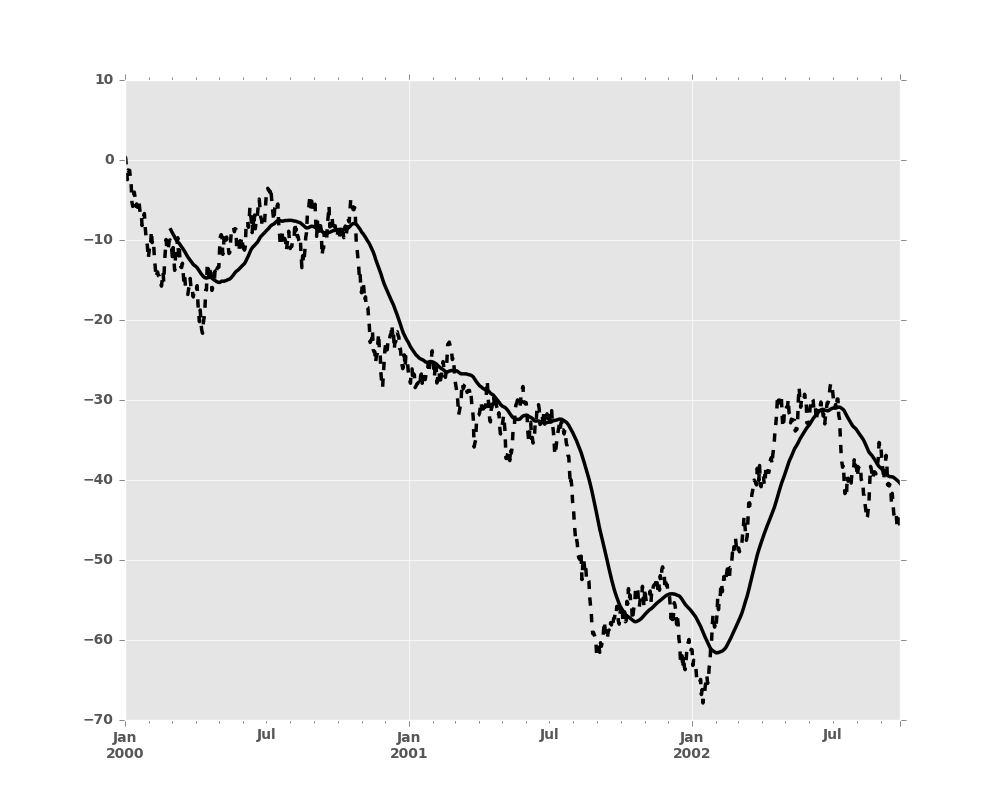

From:https://tedboy.github.io/pandas/computation/computation2.html

The next cells is for you to visualize the smoothing of the data and to find the optimal parameters. You will try out the smoothing on one example trial. You can use the example trial by changing the number stores in the variable  `col_number`.

The two most important parameters are `window_size` and `kernel_std`. The first defines the size of the rolling window that "rolls" over your data and the second one defines how big your gaussian kernel/filter is. Now you might ask, what numbers should I chose? The answer is: You just have to figure it out for your data. That is what the next cell is for. Just play around with the parameters and try to find a combination the filters out the noise but keeps the overal structure of your data.

In [ ]:
window_size=10
kernel_std=5

col_number=15
column_name=cleaned_df.columns[col_number]

series_smoothed=cleaned_df[column_name].rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)
series_not_smoothed=cleaned_df[column_name]
window=signal.gaussian(M=window_size, std=kernel_std)


grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
plt.plot(series_not_smoothed)
ax_1=plt.gca()
ax_1.set_title('Raw Data')
ax_1.set_xlabel('Time(sec)')
ax_1.set_ylabel('\u0394F/F')

plt.subplot(grid[0, 1])
plt.plot(series_smoothed, color='red') 
ax_2=plt.gca()
ax_2.set_title('Smoothed Data')
ax_2.set_xlabel('Time(sec)')
ax_2.set_ylabel('\u0394F/F')

plt.subplot(grid[1, :2])
plt.plot(window)
ax_3=plt.gca()
ax_3.set_title('Gaussian Kernel')
ax_3.set_xlabel('Sample')
ax_3.set_ylabel('Weight')
ax_3.text(0.9,0.9,'window size='+str(window_size)+'\nKernel std='+str(kernel_std),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax_3.transAxes)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()




Now that we smoothed the data we can go on and perform linear detrending, if needed.

Linear detrending is the process of removing a linear trend from the data, which can help to correct for any systematic drift or baseline changes in the data over time. This is important because calcium imaging signals can be affected by a variety of factors, such as changes in the illumination of the sample or bleaching of the fluorescent indicator, which can cause a gradual shift in the baseline over time. By removing the linear trend, the resulting data will have a more consistent baseline, which can improve the accuracy of the calcium event detection algorithm. Here you can see how data with and without bleaching looks like:

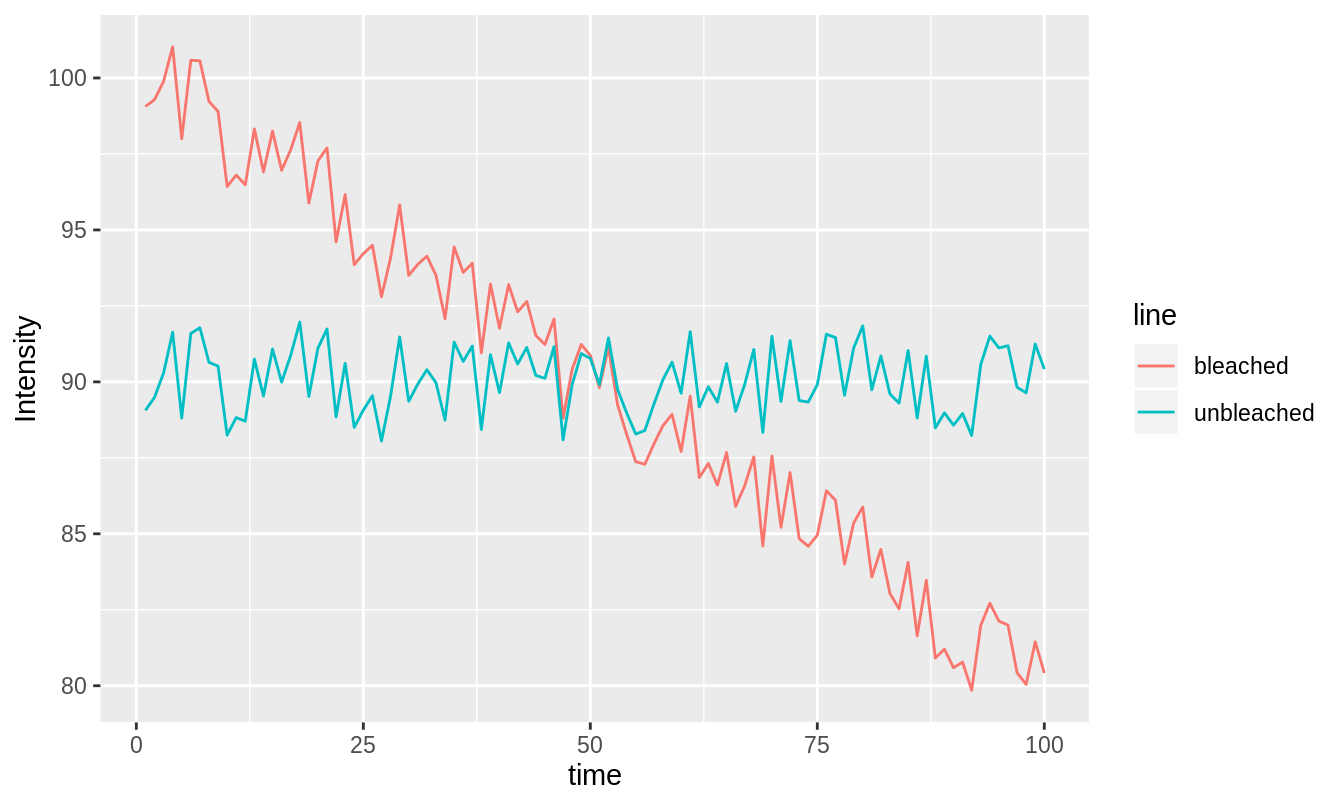

From: https://rorynolan.github.io/phdthesis/photobleaching-correction.html

**Note:** Bleaching is most likely not a purely linear event. It is probably more close to an exponential decay. However, I have not implemented this so far and for now the linear detrending is removing most of the bleaching artifacts. But you might want to work on that in the future. You can read more on that at: https://rorynolan.github.io/phdthesis/photobleaching-correction.html  

The next cells is for you to visualize the smoothing **and** the detrending of the data. You will try out the smoothing on one example trial. You can use the example trial by changing the number stores in the variable  `col_number`. First you need to put in your desired `windows_size` and `kernel_std`. After the smoothing, the linear detrending is performed. Here you do not have to change any parameters. Just decide if you are going to need a linear detrending or not.

Now you have to make a decision if you need to detrend the data. A first step is to visualize ALL cells from all trials. Here you can play around wiht the parameter `figsize=(24, 48)`.

In [ ]:
col_num=len(cleaned_df.columns)
number_of_subplots=list(range(0,len(cleaned_df.columns)))
axes=cleaned_df.plot(subplots=True, layout=(round(col_num/6)+1, 6), figsize=(24, 48), sharex=True,sharey=True, legend=None, title=number_of_subplots)

for c in axes:
   for ax in c:
      ax.axhline(y=0, color='k', ls='dashed')

plt.show()

This is the same data just plotted in one single plot.

In [ ]:
cleaned_df.plot(legend=None)
ax = plt.gca()
ax.axhline(y=0, color='k', ls='dashed')
plt.xlabel(x_label)
plt.ylabel('\u0394 F/F')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [ ]:
window_size=20
kernel_std=5

col_number=15
column_name=cleaned_df.columns[col_number]

raw_series=cleaned_df[column_name]
series_smoothed=cleaned_df[column_name].rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)

input_array=cleaned_df[column_name].to_numpy()
series_detrend=signal.detrend(input_array, bp=300)
series_detrend=pd.Series(series_detrend)
series_detrend=series_detrend.rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)

#series_not_smoothed= cleaned_df[column_name].rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)
window=signal.gaussian(M=window_size, std=kernel_std)


grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
plt.plot(raw_series)
ax_1=plt.gca()
ax_1.set_title('Raw Data')
ax_1.set_xlabel('Time(sec)')
ax_1.set_ylabel('\u0394F/F')

plt.subplot(grid[0, 1])
plt.plot(series_smoothed, color='red') 
ax_2=plt.gca()
ax_2.set_title('Smoothed Data')
ax_2.set_xlabel('Time(sec)')
ax_2.set_ylabel('\u0394F/F')

plt.subplot(grid[0, 2])
plt.plot(series_detrend, color='red') 
ax_2=plt.gca()
ax_2.set_title('Detrendet and Smoothed Data')
ax_2.set_xlabel('Time(sec)')
ax_2.set_ylabel('\u0394F/F')

plt.subplot(grid[1, :3])
plt.plot(window)
ax_3=plt.gca()
ax_3.set_title('Gaussian Kernel')
ax_3.set_xlabel('Sample')
ax_3.set_ylabel('Weight')
ax_3.text(0.9,0.9,'window size='+str(window_size)+'\nKernel std='+str(kernel_std),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax_3.transAxes)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

The calcium event probility in our example (astrocytes) basically refers to the number calcium events per minute or second. In order to calculate this, we need to find and count all peaks within the signal. This sound easy but is not a trival problem. For this we are going to use a function called `signal.find_peaks()` from the SciPy package (please see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). There are a lot of parameters that you can play around with (please look at the documentation). So far I got pretty good results with only using `height`, `width` and `distance`. I calculated the parameters as follows:

* `height=sd_threshold*baseline_mean`
* `width=calcium_event_duration*fps_rate`
* `distance=calcium_event_interval*fps_rate`
                         

This means that there are a coupled of parameters to set:

* `calcium_event_duration=0.6` (seconds)
* `calcium_event_interval=0.6` (seconds)

    --> These two parameters are initially set to 0.6 seconds based on this paper: https://www.sciencedirect.com/science/article/pii/S0896627316310078?via%3Dihub "Although it has been reported that some Ca2+ transients in astrocytes are shorter in duration (650–750 ms), we did not observe such rapid events, even when the sampling rate was increased to 15 Hz." You can always change the parameter accordingly.
<br>    

* `sd_threshold=3` this is just a definition what signal to noise ratio is needed to be defined as an event. The value is from this paper: https://onlinelibrary.wiley.com/doi/10.1002/glia.23589 "A Ca2+ signal was considered a Ca2+ event when F/F0 > 3 standard deviations greater than baseline fluorescence." You can always change this value accordingly.
<br>

* `baseline_end_time=10` (seconds)
    --> This just the time marker when your baseline ends
    
* `no_stim_start_time=0` (seconds)
    --> This just the time marker when your no-stimulation time starts

* `no_stim_end_time=60` (seconds)
    --> This just the time marker when your no-stimulation time ends

* `plot=False`
    --> Here you can decide if you want to plot every single trial

* `linear_detrending= True`
    --> Here can decide if you want to have linear detrending. 
* `gaussian_smoothing=True` 
    --> Here can decide if you want to have gaussian smoothing.
* `to_excel=False`
    --> Here you can decide if you want to save the data as an excel file to perform statistics in GraphPad
* `output_name='experiment_name'`
    --> Here you can name the experiment for exporting the excel file

In [ ]:
calcium_event_duration=0.6 #seconds
calcium_event_interval=0.6 #seconds
baseline_end_time= 10 #seconds
no_stim_start_time=0 #seconds
no_stim_end_time=60 #seconds
sd_threshold=3
plot=False
linear_detrending=True
gaussian_smoothing=True
to_excel=False
output_name='experiment_name'

In [ ]:

no_stim_frq={}
stim_frq={}
peaks_dict={}

for i in cleaned_df:
    
    if gaussian_smoothing:
        
            
        if linear_detrending:
            input_array=cleaned_df[i].to_numpy()
            series=signal.detrend(input_array)
            series=pd.Series(series)
            series=series.rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)
            
        else:
            series=cleaned_df[i].rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)
    else:
        series=cleaned_df[i]
            
        
    baseline_series=series[series.index <= baseline_end_time*fps_rate]
    baseline_sd=baseline_series.std() 
    
    series=series.reset_index(drop=True)
    peaks, properties= signal.find_peaks(series,
                         height=(sd_threshold*baseline_sd),
                         width=calcium_event_duration*fps_rate,
                         distance=calcium_event_interval*fps_rate,
                         )
    peaks_dict[i]=peaks
    #no_stim_frq[i]=(peaks<no_stim_end_time*fps_rate).sum()
    no_stim_frq[i]=((peaks>=no_stim_start_time*fps_rate) & (peaks<no_stim_end_time*fps_rate)).sum()
    #stim_frq[i]=(peaks>=no_stim_end_time*fps_rate).sum()
    stim_frq[i]=((peaks>=no_stim_end_time*fps_rate) & (peaks<stim_end_time*fps_rate)).sum()
    if plot:
        plt.plot(series) 
        plt.plot(peaks, series[peaks], "x")
        plt.plot(np.zeros_like(series), "--", color="gray")
        plt.show()
    
no_stim_frq_series=pd.Series(no_stim_frq)
stim_frq_series=pd.Series(stim_frq)

frq_df=pd.DataFrame([no_stim_frq_series,stim_frq_series])

frq_df=frq_df.transpose()
frq_df.columns=['no_stim_frq','stim_frq']

if to_excel:
    frq_df.to_excel(mypath + output_name +'.xlsx')

Now you can visualize the calcium event frequency (not probability!!!) and save the plots if you set `save_images=True`

In [ ]:
save_images=False
ax=sns.violinplot(data=frq_df)
ax.set_ylabel('Ca2+ events/min')
if save_images:
    plt.savefig((mypath + 'ATP_mean_SD_violin' + '.svg'), format = 'svg', dpi=300) 
    plt.savefig((mypath + 'ATP_mean_SD_violin' + '.png'), format = 'png', dpi=300) 
plt.show()

ax=sns.boxplot(data=frq_df)
ax.set_ylabel('Ca2+ events/min')
if save_images:
    plt.savefig((mypath + 'ATP_mean_SD_boxplot' + '.svg'), format = 'svg', dpi=300) 
    plt.savefig((mypath + 'ATP_mean_SD_boxplot' + '.png'), format = 'png', dpi=300) 
plt.show()

no_stim_frq_mean=np.array(list(no_stim_frq.values())).mean()
no_stim_frq_std=np.array(list(no_stim_frq.values())).std()


stim_frq_mean=np.array(list(no_stim_frq.values())).mean()
stim_frq_mean=np.array(list(no_stim_frq.values())).std()




Now we can actually calculate the calcium event probability. We will use this definition of the calcium event probability: "Our measurement of Ca2+ event probability was calculated as the number of Ca2+ elevations grouped in 5 s bins recorded from the astrocytes in the field of view (3–6 astrocytes per analyzed region), and mean values were obtained by averaging each different experiment." From this paper: https://onlinelibrary.wiley.com/doi/10.1002/glia.23589

In [ ]:
cleaned_df

In [ ]:
plot=True
save_images=False
start_wash_in=60
end_wash_in=120
experiment_name='8OHDPAT'


In [ ]:
list_of_peak_loc=[]
list_of_rois=[]
for i in peaks_dict:
    loc_series=pd.Series([0] * len(cleaned_df))
    peak_series=peaks_dict[i]
    loc_series[peak_series]=1
    list_of_peak_loc.append(loc_series)
    list_of_rois.append(i)

len(list_of_rois) 
len(list_of_peak_loc)   


list_of_peak_loc_df=pd.DataFrame(list_of_peak_loc)
list_of_peak_loc_df=list_of_peak_loc_df.transpose()
list_of_peak_loc_df.columns=list_of_rois

new_index=pd.TimedeltaIndex(list_of_peak_loc_df.index/fps_rate, unit='s')
list_of_peak_loc_df.index=new_index

list_of_peak_loc_df=list_of_peak_loc_df.resample("5s").sum()

event_prob_list=[]

for i in trial_name_list:
   
    non_zero=list_of_peak_loc_df.filter(like=i, axis=1).astype(bool).sum(axis=1)
    event_probability=non_zero/len(list_of_peak_loc_df.filter(like='i', axis=1).columns)
    if plot:
        
        nanosecs_fac=1000000000
        plt.plot(event_probability)
        plt.axvspan(start_wash_in*nanosecs_fac, end_wash_in*nanosecs_fac, color='grey', alpha=0.3, lw=0)
        ax=plt.gca()
        ax.set_ylabel('Ca2+ event probability')
        ax.set_xlabel('time')
        ax.set_title(i)
        if save_images:
            plt.savefig((mypath + experiment_name + '_' + i + '.svg'), format = 'svg', dpi=300) 
            plt.savefig((mypath + experiment_name + '_' + i + '.png'), format = 'png', dpi=300) 
        plt.show()
    event_prob_list.append(event_probability)
    
    
event_prob_df=pd.concat(event_prob_list, axis=1)
event_prob_df.columns=trial_name_list
if to_excel:
    event_prob_df.to_excel(mypath + experiment_name + '_' + 'event_prob' +'.xlsx')



In [ ]:
mean_event_prob=pd.concat(event_prob_list, axis=1).mean(axis=1)
std_event_prob=pd.concat(event_prob_list, axis=1).sem(axis=1)

x=list(range(0,120, 5))
plt.errorbar(x, mean_event_prob, yerr=std_event_prob, fmt='o', color='black', ecolor='gray', elinewidth=1, capsize=0, markersize=3)
plt.plot(x,mean_event_prob, color='black' ,linewidth=1)
plt.axvspan(start_wash_in, end_wash_in, color='grey', alpha=0.3, lw=0)
ax=plt.gca()
ax.set_title('Ca2+ event probability ' + experiment_name)
ax.set_xlabel('Time(sec)')
ax.set_ylabel('Ca2+ event probability')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig = plt.gcf()
fig.set_size_inches(10, 5)
if save_images:
    plt.savefig((mypath + experiment_name + '_' + 'all' + '.svg'), format = 'svg', dpi=300) 
    plt.savefig((mypath + experiment_name + '_' + 'all' + '.png'), format = 'png', dpi=300)
plt.show()